### Mirco Senes 4821270 - Computational Vision project 2024/25
## Understanding facial expressions: Feature Extraction from Facial Landmarks

This notebook presents an approach for extracting a feature vector from facial landmarks, with the objective of accurately distinguish facial expressions.

The dataset that will be used for the analysis is **KDEF (Karolinska Directed Emotional Faces)**, a well-known and widely used collection of facial images designed for research on emotion recognition. It contains high-quality pictures of individuals displaying a range of facial expressions such as happiness, anger, surprise, and neutral.

You can find more information and access the dataset here:
[KDEF Dataset - Official Page](https://www.kdef.se/)


### Facial Landmarks: Extraction and Visualization

The `extract_landmarks` function is created to extract a set of 68 facial landmarks from a given face image. This is done by using Dlib's frontal face detector along with a pre-trained shape predictor model.

The function starts by reading the input image and converting it to grayscale. Then it initializes the Dlib face detector and loads the shape predictor. The face detector identifies facial regions in the image, and if a face is detected, the shape predictor estimates the positions of 68 predefined landmark points.

The function returns these landmarks as an array of (x, y) coordinates, representing the spatial positions of facial features in the image.

In [26]:
import dlib
import numpy as np
import cv2
import matplotlib.pyplot as plt

def extract_landmarks(img_path, predictor_path="/Users/mirco/Desktop/CV2/project/shape_predictor_68_face_landmarks.dat"):
    # load image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError("Image not found!")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # initialize face detector and landmarks predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    # detect face
    faces = detector(gray)
    if len(faces) == 0:
        raise RuntimeError("No face detected!")

    face_rect = faces[0]  # use first detected face

    # landmarks extraction
    landmarks = predictor(gray, face_rect)
    coords = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

    return gray, coords

The `plot_landmarks` function displays a grayscale image of a face with the detected facial landmarks. Each landmark is plotted at its corresponding location and labeled with its index number.

In [27]:
def plot_landmarks(gray_img, coords, ax=None, show_numbers=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show = True
    else:
        show = False
    ax.imshow(gray_img, cmap='gray')
    for i, (x, y) in enumerate(coords):
        ax.plot(x, y, 'o',color='lime', markersize=3)
        if show_numbers:
            ax.text(x + 2, y - 2, str(i), color='cyan', fontsize=6)
    ax.axis('off')
    ax.set_title("Face with landmarks")
    if show:
        plt.show()

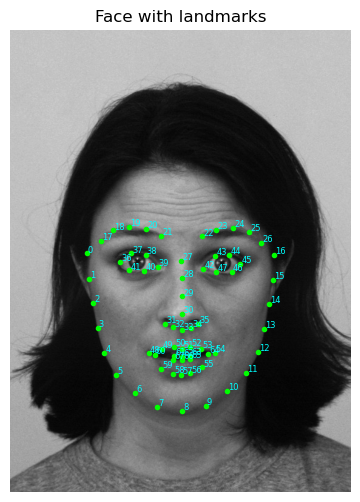

In [28]:
img_path = "KDEF/AF01/AF01SUS.JPG"
gray_img, coords = extract_landmarks(img_path)
plot_landmarks(gray_img, coords)

### Feature extraction starting from landmarks

The `extract_features` function computes a feature vector that captures key facial characteristics based on the detected facial landmarks. Given the coordinates of landmarks, the function calculates several normalized geometric measurements that represent important aspects of facial expression.

First, it computes the interocular distance (the distance between the outer corners of the eyes, points 36 and 45) as a normalization reference, ensuring the features are scale-invariant across different face sizes.

Once this normalization is established, the selected features are:

- **Left and right eye height**: The average vertical distances between the upper and lower eyelids for each eye, calculated using landmarks 37 and 41, and 38 and 40 for the left eye; and landmarks 43 and 47, and 44 and 46 for the right eye, capturing the degree of eye openness.

- **Mouth width**: The horizontal distance between the corners of the mouth, landmarks 48 and 54, representing mouth shape and expression.

- **Brow gap**: The distance between the inner ends of the eyebrows, landmarks 21 and 22, which reflects eyebrow positioning and movement.

- **Distances from mouth corners to corresponding nose points**: The distances from mouth corners (48 and 54) to the corresponding nose points (31 and 35) respectively, to detect smile.

- **Mouth angle**: The angle formed by vectors from the mouth corners (48 and 54) to the upper lip center (51), indicating mouth curvature or openness.


In [29]:
import numpy as np
def extract_features(coords):
    # normalization: interocular distance
    interocular_dist = np.linalg.norm(coords[36] - coords[45])
    if interocular_dist == 0:
        interocular_dist = 1e-6  # avoid division by zero

    # distances
    left_eye_height = np.mean([
        np.linalg.norm(coords[37] - coords[41]),
        np.linalg.norm(coords[38] - coords[40])
    ])
    right_eye_height = np.mean([
        np.linalg.norm(coords[43] - coords[47]),
        np.linalg.norm(coords[44] - coords[46])
    ])

    mouth_width = np.linalg.norm(coords[48] - coords[54])
    brow_gap = np.linalg.norm(coords[21] - coords[22])
    left_mouth_nose = np.linalg.norm(coords[48] - coords[31])
    right_mouth_nose = np.linalg.norm(coords[54] - coords[35])

    # angles
    vec1 = coords[48] - coords[51]
    vec2 = coords[54] - coords[51]
    cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    mouth_angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

    features = np.array([
        left_eye_height,
        right_eye_height,
        mouth_width,
        brow_gap,
        left_mouth_nose,
        right_mouth_nose,
        mouth_angle
    ]) / interocular_dist

    return features

The `map_feature_names` function is used to associate feature names with their corresponding values in the feature vector.

In [30]:
def map_feature_names(features_array):
    feature_names = [
        "left_eye_height",
        "right_eye_height",
        "mouth_width",
        "brow_gap",
        "left_mouth_nose",
        "right_mouth_nose",
        "mouth_angle"
    ]
    return dict(zip(feature_names, features_array))

The `euclidean_distance` function calculates the Euclidean distance between two points.

In [31]:
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

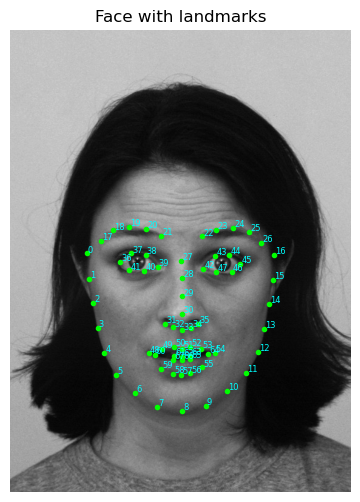

left_eye_height: 0.14
right_eye_height: 0.14
mouth_width: 0.55
brow_gap: 0.34
left_mouth_nose: 0.28
right_mouth_nose: 0.27
mouth_angle: 0.84


In [32]:
features = extract_features(coords)
feature_map = map_feature_names(features)

plot_landmarks(gray_img, coords)
for name, value in feature_map.items():
    print(f"{name}: {value:.2f}")


### Feature Selection: Minimize the Influence of Individual Facial Characteristics

The features are carefully selected to maximize their sensitivity to **facial expressions** rather than the **individual’s facial traits**.

To validate this, we start by testing on a small set of carefully chosen images:

- A single individual is compared with themselves making different facial expressions.
- The same individual is also compared with another individual making the same facial expression.

The objective is to ensure that the **distance between feature vectors representing the same expression** (but different subjects) is **minimized**, while the **distance between feature vectors of the same subject with different expressions** is **maximized**.

In other words, the feature tries to capture the variability due to **expressions** rather than individual facial characteristics, making the representation more robust for expression recognition tasks.

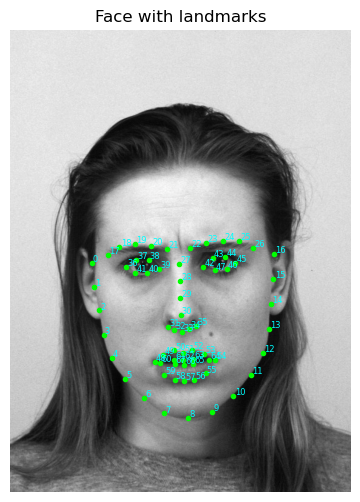

left_eye_height: 0.12
right_eye_height: 0.12
mouth_width: 0.56
brow_gap: 0.21
left_mouth_nose: 0.34
right_mouth_nose: 0.35
mouth_angle: 0.84


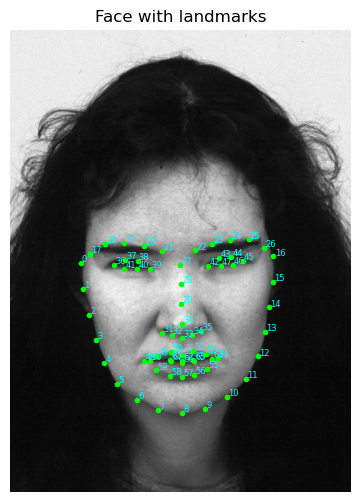

left_eye_height: 0.07
right_eye_height: 0.06
mouth_width: 0.57
brow_gap: 0.25
left_mouth_nose: 0.26
right_mouth_nose: 0.25
mouth_angle: 0.78


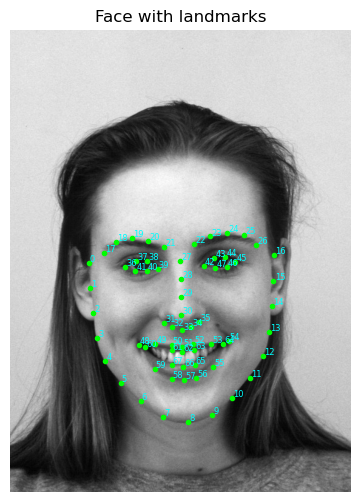

left_eye_height: 0.09
right_eye_height: 0.09
mouth_width: 0.82
brow_gap: 0.28
left_mouth_nose: 0.31
right_mouth_nose: 0.32
mouth_angle: 0.94


In [33]:
angry1 = "KDEF/AF05/AF05AFS.JPG"
angry2 = "KDEF/AF04/AF04ANS.JPG"
happy1 = "KDEF/AF05/AF05HAS.JPG"

angry1_img, angry1_coords = extract_landmarks(angry1)
angry2_img, angry2_coords = extract_landmarks(angry2)
happy1_img, happy1_coords = extract_landmarks(happy1)

angry1_features = extract_features(angry1_coords)
angry2_features = extract_features(angry2_coords)
happy1_features = extract_features(happy1_coords)

angry1_features_map = map_feature_names(angry1_features)
angry2_features_map = map_feature_names(angry2_features)
happy1_features_map = map_feature_names(happy1_features)

plot_landmarks(angry1_img, angry1_coords)
for name, value in angry1_features_map.items():
    print(f"{name}: {value:.2f}")
plot_landmarks(angry2_img, angry2_coords)
for name, value in angry2_features_map.items():
    print(f"{name}: {value:.2f}")
plot_landmarks(happy1_img, happy1_coords)
for name, value in happy1_features_map.items():
    print(f"{name}: {value:.2f}")

sim_h1_h2 = euclidean_distance(angry1_features, angry2_features)
sim_h1_s  = euclidean_distance(angry1_features, happy1_features)
sim_s_h2  = euclidean_distance(happy1_features, angry2_features)


In [34]:
print("differences")
print(f"angry1 vs angry2: {sim_h1_h2:.2f}")
print(f"angry1 vs happy1: {sim_h1_s:.2f}")
print(f"happy1 vs angry2: {sim_s_h2:.2f}")

differences
angry1 vs angry2: 0.17
angry1 vs happy1: 0.30
happy1 vs angry2: 0.31


The results appear reasonable since the closest matches involve different individuals displaying the same expression. Let’s now proceed to analyze the situation for each individual expression.

Let's start by building a function that performs the whole process.

The `analyze_emotions` function analyzes facial images by extracting features related to expressions and comparing them to a reference face.

**Steps:**

1. **Extract** facial **landmarks** and expression-related **features** from each image.
2. **Display** all images with landmarks and feature values, highlighting the reference image.
3. **Compute** and print the similarity, **distance**, between the reference and the other images based on their features.


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_emotions(image_dict):
    images = {}
    coords = {}
    features = {}
    features_map = {}

    labels = list(image_dict.keys())
    reference_label = labels[0]
    other_labels = labels[1:]

    # extract landmarks and features
    for label, path in image_dict.items():
        img, lm_coords = extract_landmarks(path)
        feat = extract_features(lm_coords)
        feat_map = map_feature_names(feat)
        images[label] = img
        coords[label] = lm_coords
        features[label] = feat
        features_map[label] = feat_map

    # plot images with landmark and feature text
    n = len(image_dict)
    fig, axs = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 6))
    plot_landmarks(images[reference_label], coords[reference_label], ax=axs[0], show_numbers=False)
    axs[0].set_title(f"REFERENCE\n{reference_label}", fontsize=10)
    feat_lines = [
        f"{name}: {value:.2f}" for name, value in features_map[reference_label].items()
    ]
    axs[0].text(
        0.98, 0.98, "\n".join(feat_lines),
        transform=axs[0].transAxes,
        fontsize=13,
        color='white',
        va='top',
        ha='right',
        family='monospace',
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2)
    )
    axs[1].axis('off')
    for i, label in enumerate(other_labels, start=2):
        plot_landmarks(images[label], coords[label], ax=axs[i], show_numbers=False)
        axs[i].set_title(label, fontsize=10)

        feat_lines = [
            f"{name}: {value:.2f}" for name, value in features_map[label].items()
        ]
        axs[i].text(
            0.98, 0.98, "\n".join(feat_lines),
            transform=axs[i].transAxes,
            fontsize=13,
            color='white',
            va='top',
            ha='right',
            family='monospace',
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2)
        )
    plt.tight_layout()
    plt.show()

    # compare reference with all others
    distances = []
    for label in other_labels:
        dist = euclidean_distance(features[reference_label], features[label])
        distances.append((dist, reference_label, label))
    distances.sort()

    # print results
    print(f"Top {min(4, len(distances))} matches to reference ({reference_label}):")
    for dist, ref, lbl in distances[:4]:
        print(f"{ref} vs {lbl}: {dist:.2f}")


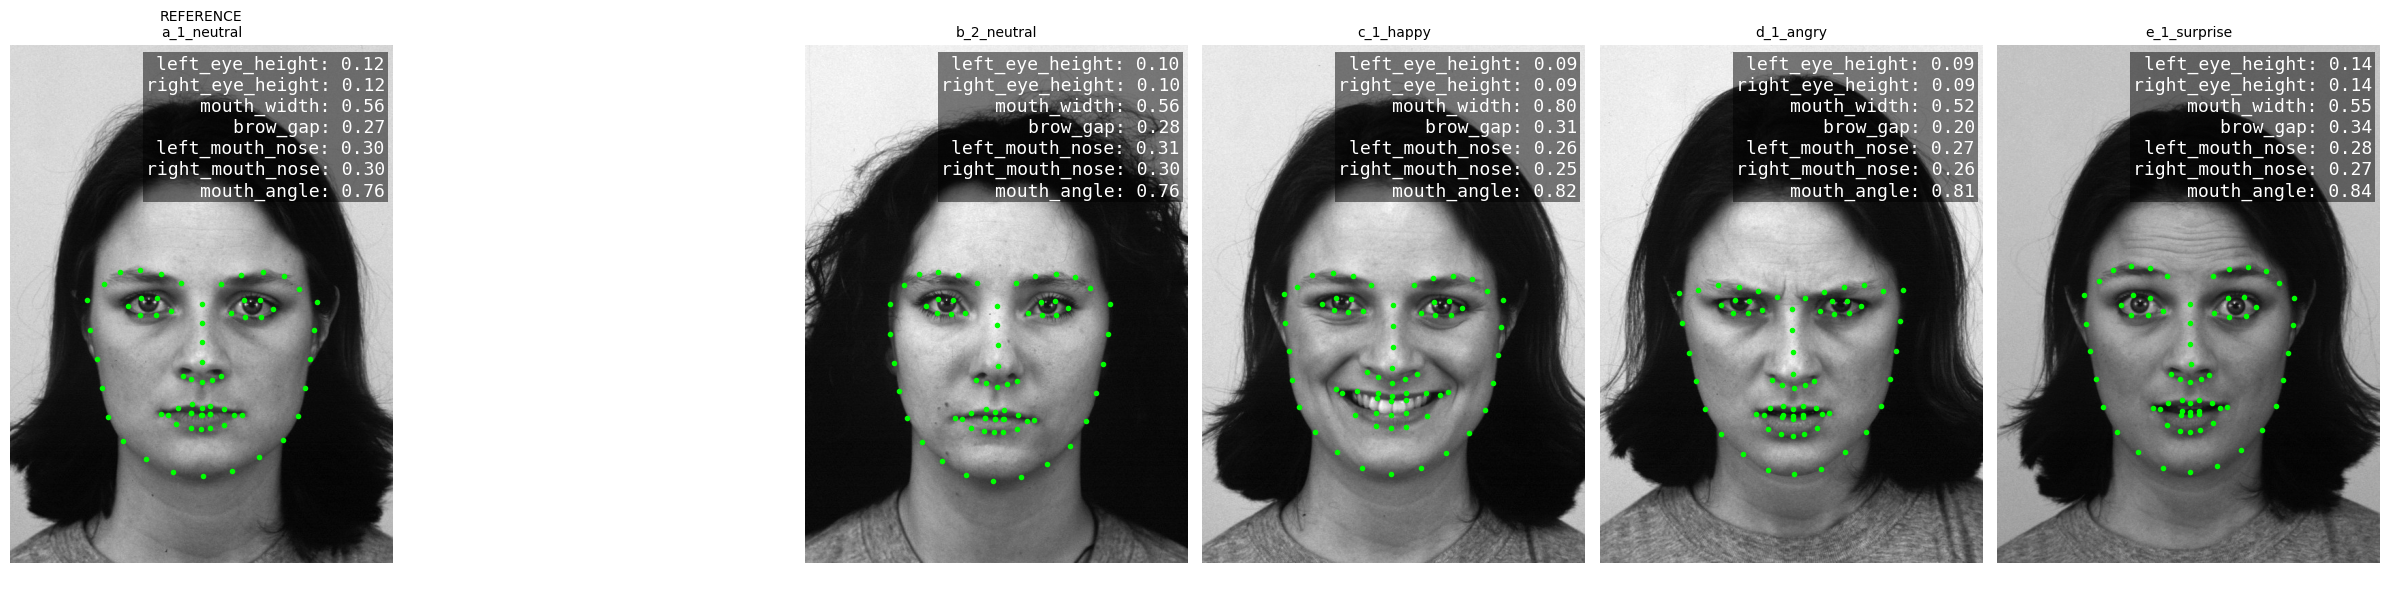

Top 4 matches to reference (a_1_neutral):
a_1_neutral vs b_2_neutral: 0.03
a_1_neutral vs e_1_surprise: 0.11
a_1_neutral vs d_1_angry: 0.12
a_1_neutral vs c_1_happy: 0.26


In [36]:
image_dict = {
    "a_1_neutral": "KDEF/AF01/AF01NES.JPG",
    "b_2_neutral" : "KDEF/AF02/AF02NES.JPG",
    "c_1_happy": "KDEF/AF01/AF01HAS.JPG",
    "d_1_angry": "KDEF/AF01/AF01ANS.JPG",
    "e_1_surprise": "KDEF/AF01/AF01SUS.JPG",
}

analyze_emotions(image_dict)

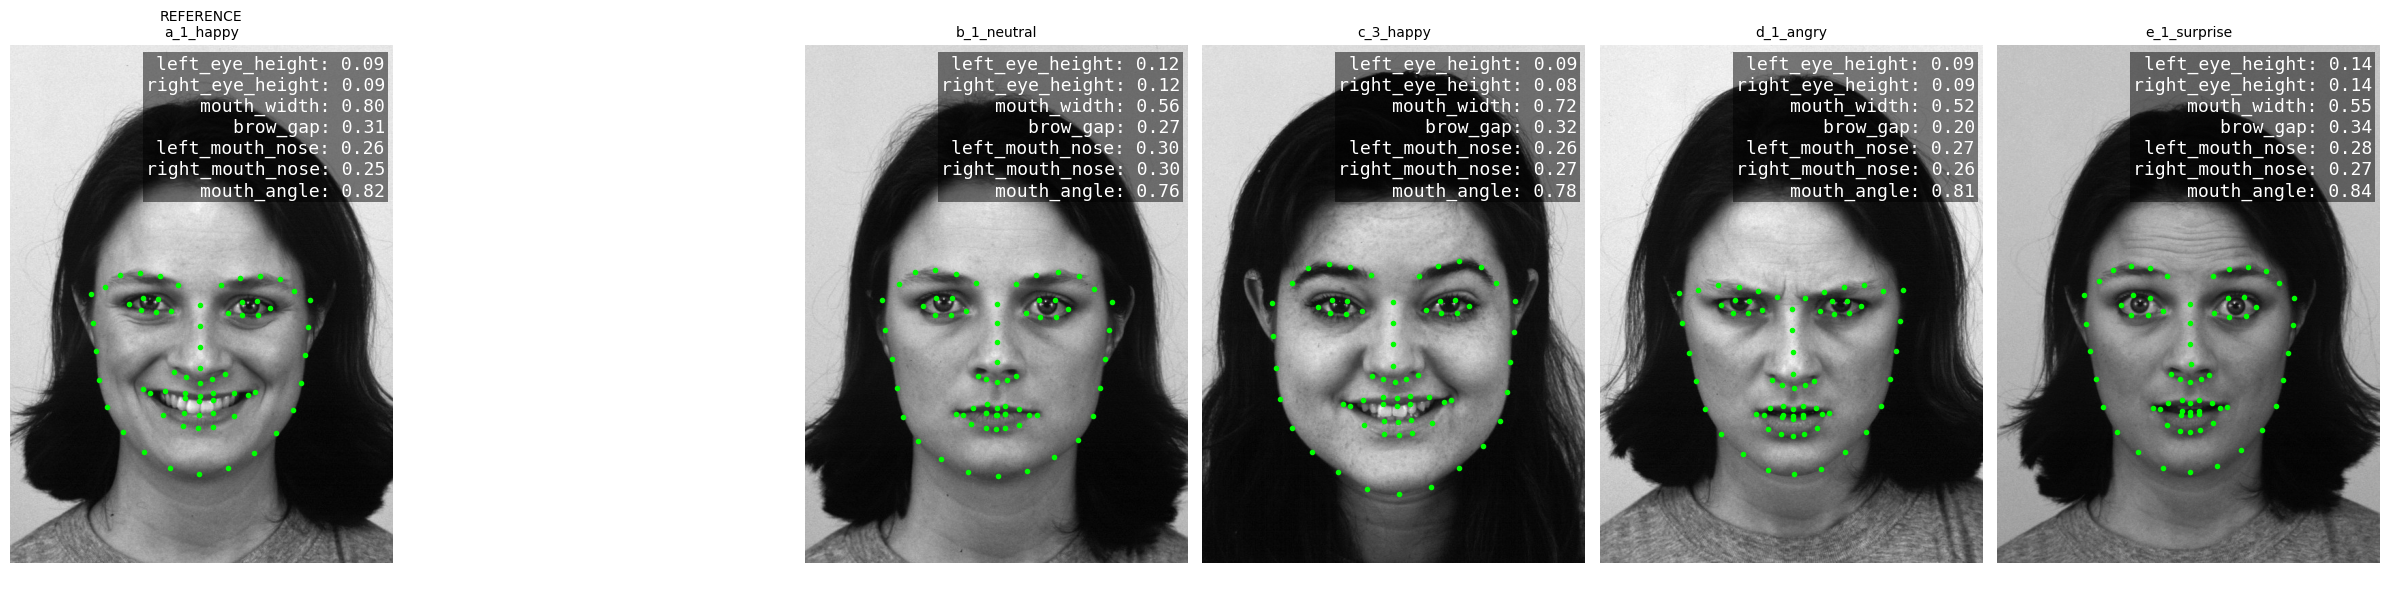

Top 4 matches to reference (a_1_happy):
a_1_happy vs c_3_happy: 0.10
a_1_happy vs b_1_neutral: 0.26
a_1_happy vs e_1_surprise: 0.26
a_1_happy vs d_1_angry: 0.30


In [37]:
image_dict = {
    "a_1_happy": "KDEF/AF01/AF01HAS.JPG",
    "b_1_neutral": "KDEF/AF01/AF01NES.JPG",
    "c_3_happy": "KDEF/AF03/AF03HAS.JPG",
    "d_1_angry": "KDEF/AF01/AF01ANS.JPG",
    "e_1_surprise": "KDEF/AF01/AF01SUS.JPG",
}
analyze_emotions(image_dict)

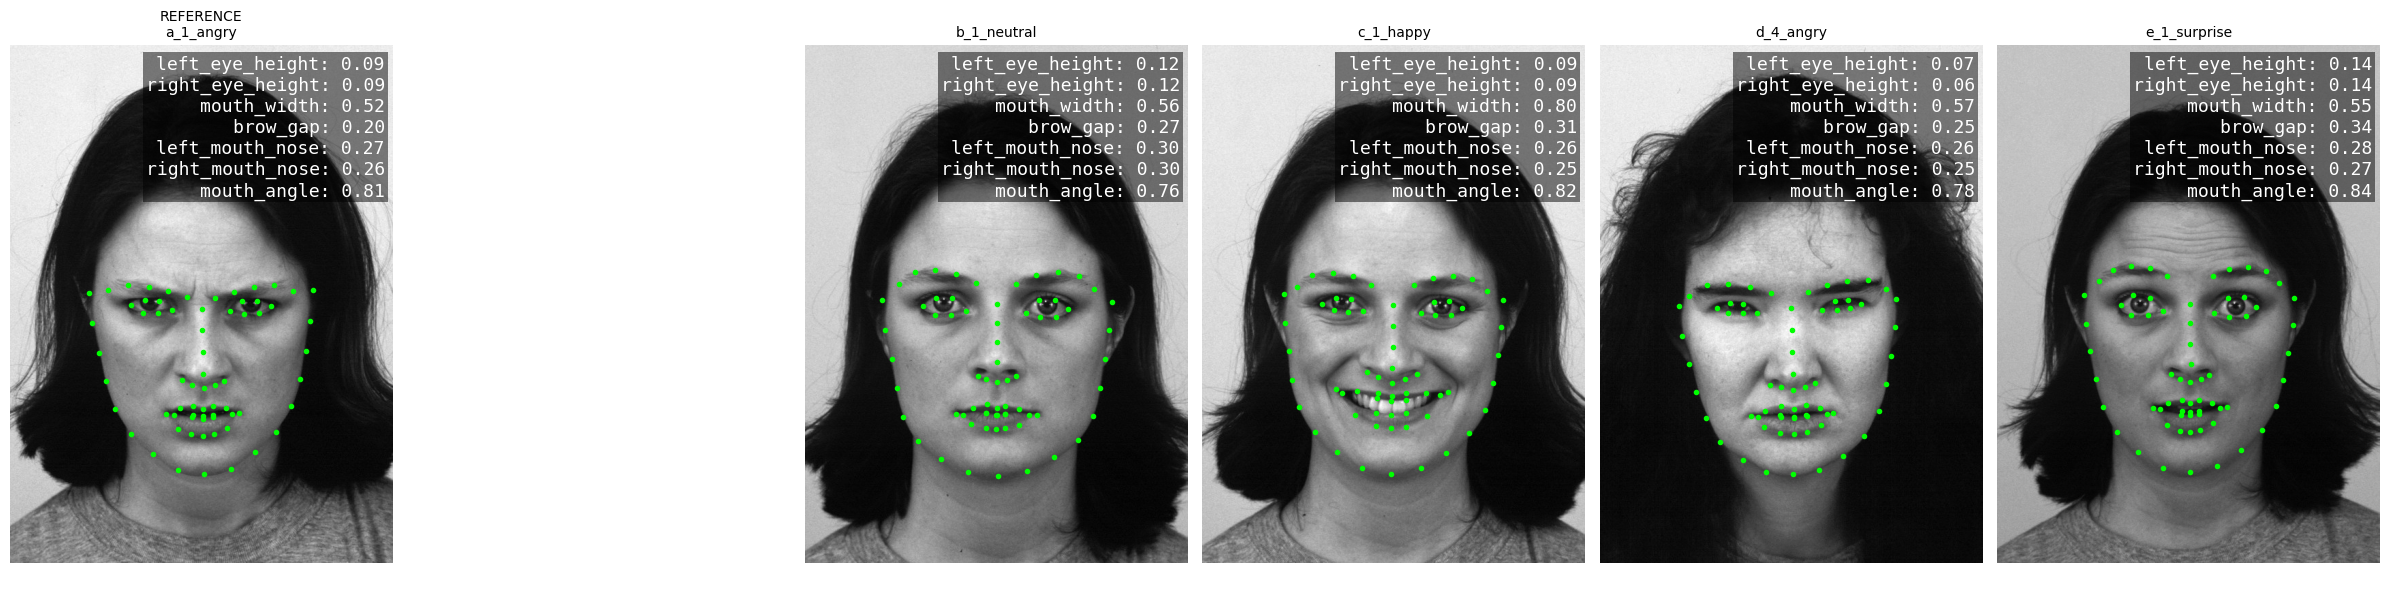

Top 4 matches to reference (a_1_angry):
a_1_angry vs d_4_angry: 0.09
a_1_angry vs b_1_neutral: 0.12
a_1_angry vs e_1_surprise: 0.17
a_1_angry vs c_1_happy: 0.30


In [38]:
image_dict = {
    "a_1_angry": "KDEF/AF01/AF01ANS.JPG",
    "b_1_neutral": "KDEF/AF01/AF01NES.JPG",
    "c_1_happy": "KDEF/AF01/AF01HAS.JPG",
    "d_4_angry": "KDEF/AF04/AF04ANS.JPG",
    "e_1_surprise": "KDEF/AF01/AF01SUS.JPG",
}
analyze_emotions(image_dict)


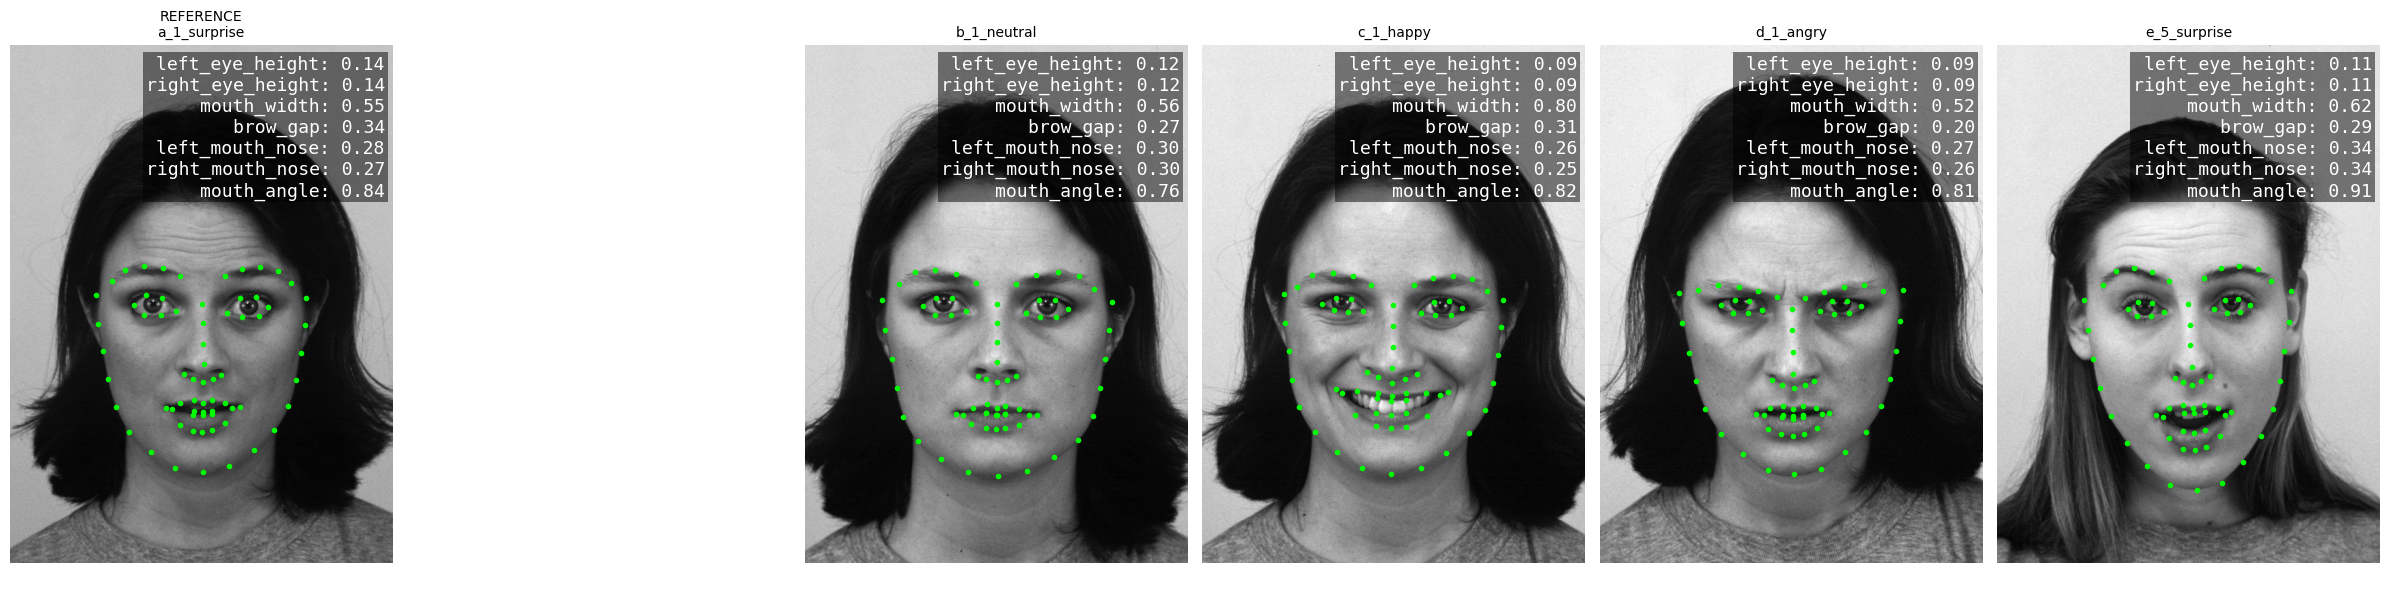

Top 4 matches to reference (a_1_surprise):
a_1_surprise vs b_1_neutral: 0.11
a_1_surprise vs e_5_surprise: 0.15
a_1_surprise vs d_1_angry: 0.17
a_1_surprise vs c_1_happy: 0.26


In [39]:
image_dict = {
    "a_1_surprise": "KDEF/AF01/AF01SUS.JPG",
    "b_1_neutral": "KDEF/AF01/AF01NES.JPG",
    "c_1_happy": "KDEF/AF01/AF01HAS.JPG",
    "d_1_angry": "KDEF/AF01/AF01ANS.JPG",
    "e_5_surprise": "KDEF/AF05/AF05SUS.JPG",
}
analyze_emotions(image_dict)

**Happiness** appears to be the **most** easily **distinguishable** emotion, while neutral, anger, and surprise show closer distance values to each other, suggesting less clear discrimination.

However, this might be an isolated case. Therefore, we will proceed with an analysis of the entire dataset before making any changes to the selected features.

### Testing on the Whole Dataset



The function `analyze_and_cluster` takes a set of facial images and performs the following steps:

1. **Feature Extraction**: It extracts facial landmarks with `extract_landmarks` and computes feature vectors for each image using `extract_features`, representing the facial expressions.

2. **Clustering**: Applies K-Means clustering on the extracted features to group images into **k clusters** (default is 4), helping to identify natural groupings based on expression features.

3. **Optional Dataset Visualization**: If enabled, it displays the dataset images arranged by subject and emotion (neutral, happy, angry, surprise) for visual comparison.

4. **Dimensionality Reduction and Plotting**: Uses PCA to reduce feature dimensions to 2D and plots the clustered data points with annotations showing the emotion and subject.

5. **Output**: Returns a dictionary linking each image label to its cluster assignment.

This function enables analysis of how well the selected features capture differences in facial expressions across individuals and facilitates visual interpretation of clustering results.


In [40]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def analyze_and_cluster(image_dict, k=4, visualize=True, plot_faces=False):
    features = {}
    images = {}
    labels = []
    landmarks = {}
    failed = []

    # extract landmark and features
    for label, path in image_dict.items():
        try:
            img, lm_coords = extract_landmarks(path)
            feat = extract_features(lm_coords)
            features[label] = feat
            images[label] = img
            landmarks[label] = lm_coords
            labels.append(label)
        except Exception as e:
            print(f"Error with {label}: {e}")
            failed.append(label)

    if not features:
        raise ValueError("No valid features found")

    # build feature matrix
    feature_matrix = np.array([features[label] for label in labels])

    # clustering with kMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    # plotting facial images with landmarks
    if plot_faces:
        subject_images = defaultdict(dict)
        for label in labels:
            emotion, subject = label.split('_')
            subject_images[subject][emotion] = images[label]

        emotions_order = ['neutral', 'happy', 'angry', 'surprise']
        num_subjects = len(subject_images)
        fig, axs = plt.subplots(num_subjects, 4, figsize=(12, 3 * num_subjects))

        if num_subjects == 1:
            axs = np.array([axs])

        for row_idx, (subject, emo_dict) in enumerate(sorted(subject_images.items(), key=lambda x: int(x[0]))):
            for col_idx, emo in enumerate(emotions_order):
                ax = axs[row_idx, col_idx]
                label = f"{emo}_{subject}"
                img = emo_dict.get(emo)
                if img is not None:
                    coords = landmarks.get(label)
                    if coords is not None:
                        plot_landmarks(img, coords, ax=ax, show_numbers=False)
                    else:
                        ax.imshow(img, cmap='gray')
                    ax.set_title(f"{emo}{row_idx + 1}", fontsize=9)
                else:
                    ax.axis('off')
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    # PCA visualization
    if visualize:
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(feature_matrix)

        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=50)
        for i, label in enumerate(labels):
            emotion, subject = label.split('_')
            abbrev = f"{emotion[0].upper()}{subject}"
            plt.annotate(abbrev, (reduced[i, 0], reduced[i, 1]), fontsize=8)
        plt.title(f"Expressions clustering (k={k})")
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.grid(True)
        plt.show()

    return dict(zip(labels, cluster_labels))

**imgs_dict** is the input dictionary where each key is a label combining an emotion (like neutral, happy, angry, surprise) and a subject ID (e.g., '01', '02'), and each value is the file path to the corresponding facial image from the KDEF dataset.

In [41]:
imgs_dict = {
    'neutral_01': 'KDEF/AF01/AF01NES.JPG',
    'happy_01': 'KDEF/AF01/AF01HAS.JPG',
    'angry_01': 'KDEF/AF01/AF01ANS.JPG',
    'surprise_01': 'KDEF/AF01/AF01SUS.JPG',
    'neutral_02': 'KDEF/AF02/AF02NES.JPG',
    'happy_02': 'KDEF/AF02/AF02HAS.JPG',
    'angry_02': 'KDEF/AF02/AF02ANS.JPG',
    'surprise_02': 'KDEF/AF02/AF02SUS.JPG',
    'neutral_03': 'KDEF/AF03/AF03NES.JPG',
    'happy_03': 'KDEF/AF03/AF03HAS.JPG',
    'angry_03': 'KDEF/AF03/AF03ANS.JPG',
    'surprise_03': 'KDEF/AF03/AF03SUS.JPG',
    'neutral_04': 'KDEF/AF04/AF04NES.JPG',
    'happy_04': 'KDEF/AF04/AF04HAS.JPG',
    'angry_04': 'KDEF/AF04/AF04ANS.JPG',
    'surprise_04': 'KDEF/AF04/AF04SUS.JPG',
    'neutral_05': 'KDEF/AF05/AF05NES.JPG',
    'happy_05': 'KDEF/AF05/AF05HAS.JPG',
    'angry_05': 'KDEF/AF05/AF05ANS.JPG',
    'surprise_05': 'KDEF/AF05/AF05SUS.JPG',
    'neutral_06': 'KDEF/AF06/AF06NES.JPG',
    'happy_06': 'KDEF/AF06/AF06HAS.JPG',
    'angry_06': 'KDEF/AF06/AF06ANS.JPG',
    'surprise_06': 'KDEF/AF06/AF06SUS.JPG',
    'neutral_07': 'KDEF/AF07/AF07NES.JPG',
    'happy_07': 'KDEF/AF07/AF07HAS.JPG',
    'angry_07': 'KDEF/AF07/AF07ANS.JPG',
    'surprise_07': 'KDEF/AF07/AF07SUS.JPG',
    'neutral_08': 'KDEF/AF08/AF08NES.JPG',
    'happy_08': 'KDEF/AF08/AF08HAS.JPG',
    'angry_08': 'KDEF/AF08/AF08ANS.JPG',
    'surprise_08': 'KDEF/AF08/AF08SUS.JPG',
    'neutral_09': 'KDEF/AF09/AF09NES.JPG',
    'happy_09': 'KDEF/AF09/AF09HAS.JPG',
    'angry_09': 'KDEF/AF09/AF09ANS.JPG',
    'surprise_09': 'KDEF/AF09/AF09SUS.JPG',
    'neutral_10': 'KDEF/AF10/AF10NES.JPG',
    'happy_10': 'KDEF/AF10/AF10HAS.JPG',
    'angry_10': 'KDEF/AF10/AF10ANS.JPG',
    'surprise_10': 'KDEF/AF10/AF10SUS.JPG',
    'neutral_11': 'KDEF/AF11/AF11NES.JPG',
    'happy_11': 'KDEF/AF11/AF11HAS.JPG',
    'angry_11': 'KDEF/AF11/AF11ANS.JPG',
    'surprise_11': 'KDEF/AF11/AF11SUS.JPG',
    'neutral_12': 'KDEF/AF12/AF12NES.JPG',
    'happy_12': 'KDEF/AF12/AF12HAS.JPG',
    'angry_12': 'KDEF/AF12/AF12ANS.JPG',
    'surprise_12': 'KDEF/AF12/AF12SUS.JPG',
    'neutral_13': 'KDEF/AF13/AF13NES.JPG',
    'happy_13': 'KDEF/AF13/AF13HAS.JPG',
    'angry_13': 'KDEF/AF13/AF13ANS.JPG',
    'surprise_13': 'KDEF/AF13/AF13SUS.JPG',
    'neutral_14': 'KDEF/AF14/AF14NES.JPG',
    'happy_14': 'KDEF/AF14/AF14HAS.JPG',
    'angry_14': 'KDEF/AF14/AF14ANS.JPG',
    'surprise_14': 'KDEF/AF14/AF14SUS.JPG',
    'neutral_15': 'KDEF/AF15/AF15NES.JPG',
    'happy_15': 'KDEF/AF15/AF15HAS.JPG',
    'angry_15': 'KDEF/AF15/AF15ANS.JPG',
    'surprise_15': 'KDEF/AF15/AF15SUS.JPG',
    'neutral_16': 'KDEF/AF16/AF16NES.JPG',
    'happy_16': 'KDEF/AF16/AF16HAS.JPG',
    'angry_16': 'KDEF/AF16/AF16ANS.JPG',
    'surprise_16': 'KDEF/AF16/AF16SUS.JPG',
    'neutral_17': 'KDEF/AF17/AF17NES.JPG',
    'happy_17': 'KDEF/AF17/AF17HAS.JPG',
    'angry_17': 'KDEF/AF17/AF17ANS.JPG',
    'surprise_17': 'KDEF/AF17/AF17SUS.JPG',
    'neutral_18': 'KDEF/AF18/AF18NES.JPG',
    'happy_18': 'KDEF/AF18/AF18HAS.JPG',
    'angry_18': 'KDEF/AF18/AF18ANS.JPG',
    'surprise_18': 'KDEF/AF18/AF18SUS.JPG',
    'neutral_19': 'KDEF/AF19/AF19NES.JPG',
    'happy_19': 'KDEF/AF19/AF19HAS.JPG',
    'angry_19': 'KDEF/AF19/AF19ANS.JPG',
    'surprise_19': 'KDEF/AF19/AF19SUS.JPG',
    'neutral_20': 'KDEF/AF20/AF20NES.JPG',
    'happy_20': 'KDEF/AF20/AF20HAS.JPG',
    'angry_20': 'KDEF/AF20/AF20ANS.JPG',
    'surprise_20': 'KDEF/AF20/AF20SUS.JPG',
    'neutral_21': 'KDEF/AF21/AF21NES.JPG',
    'happy_21': 'KDEF/AF21/AF21HAS.JPG',
    'angry_21': 'KDEF/AF21/AF21ANS.JPG',
    'surprise_21': 'KDEF/AF21/AF21SUS.JPG',
    'neutral_22': 'KDEF/AF22/AF22NES.JPG',
    'happy_22': 'KDEF/AF22/AF22HAS.JPG',
    'angry_22': 'KDEF/AF22/AF22ANS.JPG',
    'surprise_22': 'KDEF/AF22/AF22SUS.JPG',
    'neutral_23': 'KDEF/AF23/AF23NES.JPG',
    'happy_23': 'KDEF/AF23/AF23HAS.JPG',
    'angry_23': 'KDEF/AF23/AF23ANS.JPG',
    'surprise_23': 'KDEF/AF23/AF23SUS.JPG',
    'neutral_24': 'KDEF/AF24/AF24NES.JPG',
    'happy_24': 'KDEF/AF24/AF24HAS.JPG',
    'angry_24': 'KDEF/AF24/AF24ANS.JPG',
    'surprise_24': 'KDEF/AF24/AF24SUS.JPG',
    'neutral_25': 'KDEF/AF25/AF25NES.JPG',
    'happy_25': 'KDEF/AF25/AF25HAS.JPG',
    'angry_25': 'KDEF/AF25/AF25ANS.JPG',
    'surprise_25': 'KDEF/AF25/AF25SUS.JPG',
    'neutral_26': 'KDEF/AF26/AF26NES.JPG',
    'happy_26': 'KDEF/AF26/AF26HAS.JPG',
    'angry_26': 'KDEF/AF26/AF26ANS.JPG',
    'surprise_26': 'KDEF/AF26/AF26SUS.JPG',
    'neutral_27': 'KDEF/AF27/AF27NES.JPG',
    'happy_27': 'KDEF/AF27/AF27HAS.JPG',
    'angry_27': 'KDEF/AF27/AF27ANS.JPG',
    'surprise_27': 'KDEF/AF27/AF27SUS.JPG',
    'neutral_28': 'KDEF/AF28/AF28NES.JPG',
    'happy_28': 'KDEF/AF28/AF28HAS.JPG',
    'angry_28': 'KDEF/AF28/AF28ANS.JPG',
    'surprise_28': 'KDEF/AF28/AF28SUS.JPG',
    'neutral_29': 'KDEF/AF29/AF29NES.JPG',
    'happy_29': 'KDEF/AF29/AF29HAS.JPG',
    'angry_29': 'KDEF/AF29/AF29ANS.JPG',
    'surprise_29': 'KDEF/AF29/AF29SUS.JPG',
    'neutral_30': 'KDEF/AF30/AF30NES.JPG',
    'happy_30': 'KDEF/AF30/AF30HAS.JPG',
    'angry_30': 'KDEF/AF30/AF30ANS.JPG',
    'surprise_30': 'KDEF/AF30/AF30SUS.JPG'
}

/Users/mirco/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


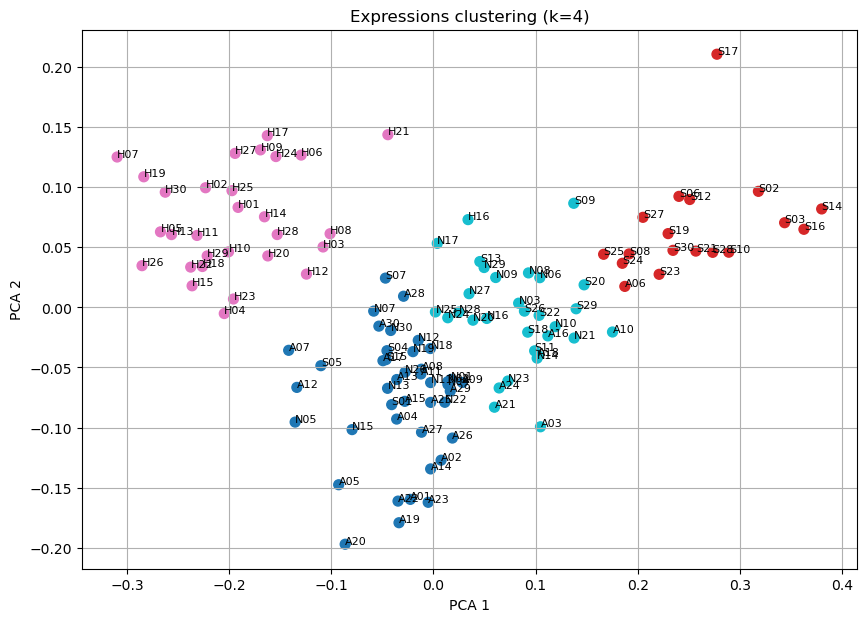

Cluster 0: ['neutral_01', 'angry_01', 'surprise_01', 'neutral_02', 'angry_02', 'neutral_04', 'angry_04', 'surprise_04', 'neutral_05', 'angry_05', 'surprise_05', 'neutral_07', 'angry_07', 'surprise_07', 'angry_08', 'angry_09', 'neutral_11', 'angry_11', 'neutral_12', 'angry_12', 'neutral_13', 'angry_13', 'angry_14', 'neutral_15', 'angry_15', 'surprise_15', 'angry_17', 'neutral_18', 'neutral_19', 'angry_19', 'angry_20', 'neutral_22', 'angry_22', 'angry_23', 'angry_25', 'neutral_26', 'angry_26', 'angry_27', 'angry_28', 'angry_29', 'neutral_30', 'angry_30']
Cluster 1: ['surprise_02', 'surprise_03', 'angry_06', 'surprise_06', 'surprise_08', 'surprise_10', 'surprise_12', 'surprise_14', 'surprise_16', 'surprise_17', 'surprise_19', 'surprise_21', 'surprise_23', 'surprise_24', 'surprise_25', 'surprise_27', 'surprise_28', 'surprise_30']
Cluster 2: ['happy_01', 'happy_02', 'happy_03', 'happy_04', 'happy_05', 'happy_06', 'happy_07', 'happy_08', 'happy_09', 'happy_10', 'happy_11', 'happy_12', 'happy

In [42]:
cluster_assignments = analyze_and_cluster(imgs_dict, k=4, visualize=True, plot_faces=False)

for cluster_id in range(4):
    group = [label for label, cid in cluster_assignments.items() if cid == cluster_id]
    print(f"Cluster {cluster_id}: {group}")

The clustering results show a clear pattern regarding the emotional expressions:

- Cluster 2 is very clean and **distinct**, containing almost exclusively **happy expressions**. This suggests that the happiness expression is easily separable and well captured by the features.

- Cluster 1 mostly groups surprise expressions, indicating that **surprise tends to cluster together**, though not as distinctly as happiness.

- Clusters 0 and 3 are more mixed and contain a combination of **neutral, angry, and some surprise expressions**. This suggests that these emotions are **harder to distinguish** from each other based on the current features, leading to overlap between clusters.

This seems reasonable since, when observing neutral and angry faces, it is often difficult to distinguish between them; some people even appear angry when their expression is neutral.

Let's try to modify the features to better distinguish these two expressions.

### Feature Modification: Distinguishing Angry vs Neutral Faces
Intuitively, one of the most noticeable differences between an actually angry face and a neutral one is the frowning of the eyebrows.

However, calculating the slope or curvature of the eyebrows would depend too much on the individual shape of each person’s eyebrows, which can vary a lot.

After careful observation of the dataset, I decided to introduce a more robust feature: the **vertical distance between the upper eyelid and the eyebrow**. This distance better captures the eyebrow movement **related to anger** (eyebrows tend to be lowered and closer to the eyes when angry).

The landmarks involved are:

- For the left eye and eyebrow: eyebrow top (20) and upper eyelid points (37 and 38 averaged)

- For the right eye and eyebrow: eyebrow top (23) and upper eyelid points (landmarks 43 and 44 averaged)

Moreover, this distance is potentially useful to **distinguish** the **surprise cluster**, as surprised faces tend to increase the distance between eyelids and eyebrows.

In [43]:
def extract_features(coords):
    interocular_dist = np.linalg.norm(coords[36] - coords[45])
    if interocular_dist == 0:
        interocular_dist = 1e-6

    left_eye_height = np.mean([
        np.linalg.norm(coords[37] - coords[41]),
        np.linalg.norm(coords[38] - coords[40])
    ])
    right_eye_height = np.mean([
        np.linalg.norm(coords[43] - coords[47]),
        np.linalg.norm(coords[44] - coords[46])
    ])

    mouth_width = np.linalg.norm(coords[48] - coords[54])
    brow_gap = np.linalg.norm(coords[21] - coords[22])
    left_mouth_nose = np.linalg.norm(coords[48] - coords[31])
    right_mouth_nose = np.linalg.norm(coords[54] - coords[35])

    vec1 = coords[48] - coords[51]
    vec2 = coords[54] - coords[51]
    cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    mouth_angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

    # vertical distance between the upper eyelid and the eyebrow
    left_brow_top = coords[20]
    left_upper_lid = np.mean([coords[37], coords[38]], axis=0)
    left_brow_eyelid = left_upper_lid[1] - left_brow_top[1]

    right_brow_top = coords[23]
    right_upper_lid = np.mean([coords[43], coords[44]], axis=0)
    right_brow_eyelid = right_upper_lid[1] - right_brow_top[1]

    features = np.array([
        left_eye_height,
        right_eye_height,
        mouth_width,
        brow_gap,
        left_mouth_nose,
        right_mouth_nose,
        mouth_angle,
        left_brow_eyelid,
        right_brow_eyelid
    ]) / interocular_dist

    return features

/Users/mirco/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


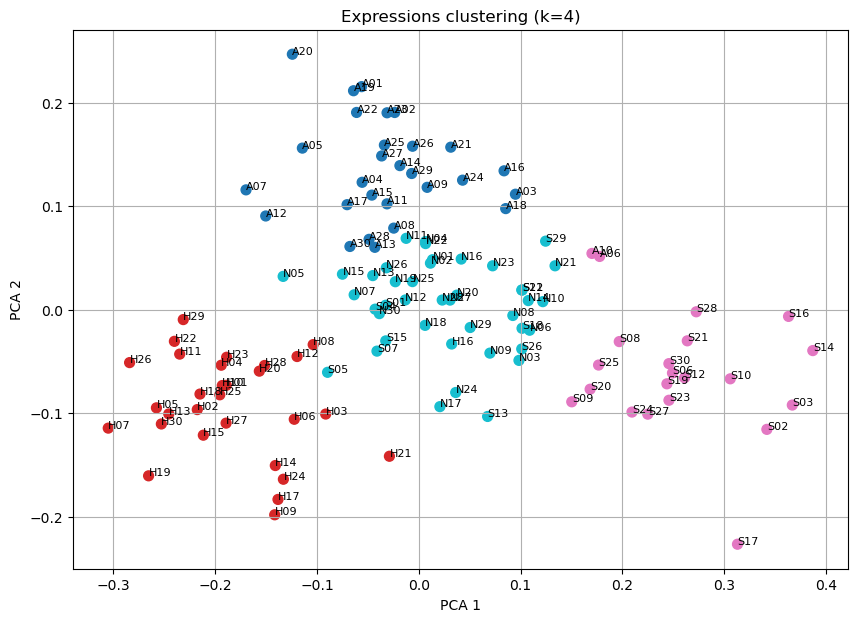

Cluster 0: ['angry_01', 'angry_02', 'angry_03', 'angry_04', 'angry_05', 'angry_07', 'angry_08', 'angry_09', 'angry_11', 'angry_12', 'angry_13', 'angry_14', 'angry_15', 'angry_16', 'angry_17', 'angry_18', 'angry_19', 'angry_20', 'angry_21', 'angry_22', 'angry_23', 'angry_24', 'angry_25', 'angry_26', 'angry_27', 'angry_28', 'angry_29', 'angry_30']
Cluster 1: ['happy_01', 'happy_02', 'happy_03', 'happy_04', 'happy_05', 'happy_06', 'happy_07', 'happy_08', 'happy_09', 'happy_10', 'happy_11', 'happy_12', 'happy_13', 'happy_14', 'happy_15', 'happy_17', 'happy_18', 'happy_19', 'happy_20', 'happy_21', 'happy_22', 'happy_23', 'happy_24', 'happy_25', 'happy_26', 'happy_27', 'happy_28', 'happy_29', 'happy_30']
Cluster 2: ['surprise_02', 'surprise_03', 'angry_06', 'surprise_06', 'surprise_08', 'surprise_09', 'angry_10', 'surprise_10', 'surprise_12', 'surprise_14', 'surprise_16', 'surprise_17', 'surprise_19', 'surprise_20', 'surprise_21', 'surprise_23', 'surprise_24', 'surprise_25', 'surprise_27', '

In [44]:
cluster_assignments = analyze_and_cluster(imgs_dict, k=4, visualize=True )
for cluster_id in range(4):
    group = [label for label, cid in cluster_assignments.items() if cid == cluster_id]
    print(f"Cluster {cluster_id}: {group}")

The distinction between the clusters now appears much clearer than before. Let’s analyze the details:

- Cluster 0: now contains **exclusively angry expressions**. This suggests the model is better at distinguishing anger, reducing confusion with neutral faces.

- Cluster 2: mostly surprise expressions, with a couple of angry samples mixed in. The **surprise cluster** is now **more clearly separated** than before.

- Cluster 1: remains a **very clean cluster of happy expressions**, consistent with the previous clustering.

- Cluster 3: mostly contains **neutral expressions**, some surprise, and a few angry or happy samples scattered in. This cluster **still has some mixing** but is primarily neutral.

#### Final 9-Dimensional Feature Vector

1. **Left eye height** – average of distances between points **(37–41)** and **(38–40)**

2. **Right eye height** – average of distances between points **(43–47)** and **(44–46)**

3. **Mouth width** – distance between points **48** and **54**

4. **Eyebrow gap** – distance between points **21** and **22**

5. **Left mouth-to-nose** – distance between points **48** and **31**

6. **Right mouth-to-nose** – distance between points **54** and **35**

7. **Mouth angle** – angle at point **51** between vectors **(48–51)** and **(54–51)**

8. **Left brow-eyelid distance** – vertical distance between average of **(37, 38)** and point **20**

9. **Right brow-eyelid distance** – vertical distance between average of **(43, 44)** and point **23**


### Personal Dataset Testing

We now evaluate the developed method on a small, custom-generated dataset to assess how well the implementation generalizes beyond the original data.

/Users/mirco/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


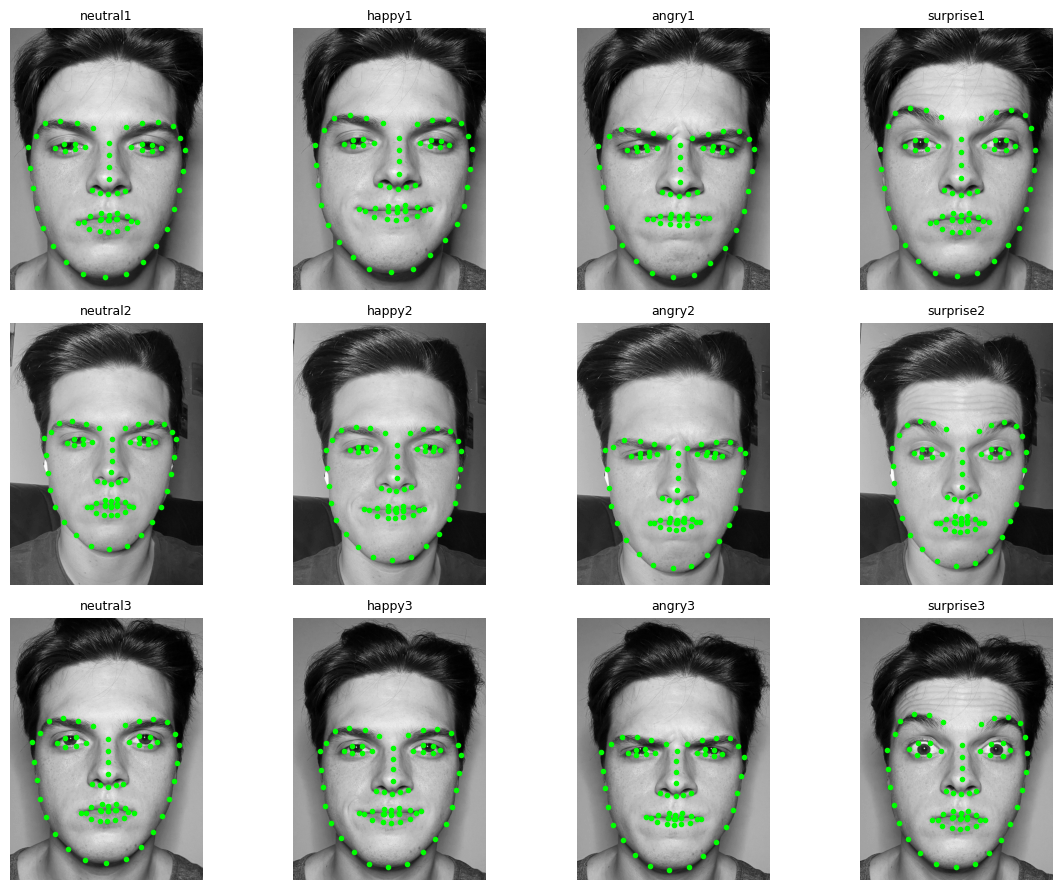

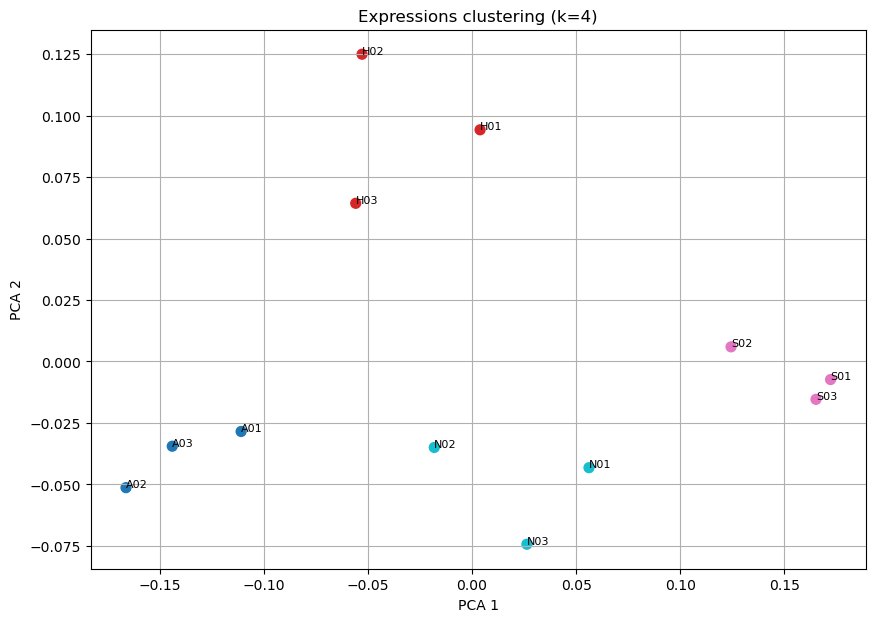

Cluster 0: ['angry_01', 'angry_02', 'angry_03']
Cluster 1: ['happy_01', 'happy_02', 'happy_03']
Cluster 2: ['surprise_01', 'surprise_02', 'surprise_03']
Cluster 3: ['neutral_01', 'neutral_02', 'neutral_03']


In [45]:
personal_dict = {
    'neutral_01': 'my_data/neutral4.jpg',
    'happy_01': 'my_data/happy4.jpg',
    'angry_01': 'my_data/angry4.jpg',
    'surprise_01': 'my_data/surprise4.jpg',

    'neutral_02': 'my_data/neutral02.jpg',
    'happy_02': 'my_data/happy02.jpg',
    'angry_02': 'my_data/angry02.jpg',
    'surprise_02': 'my_data/surprise02.jpg',

    'neutral_03': 'my_data/neutral5.jpg',
    'happy_03': 'my_data/happy5.jpg',
    'angry_03': 'my_data/angry5.jpg',
    'surprise_03': 'my_data/surprise5.jpg',
}

cluster_assignments = analyze_and_cluster(personal_dict, k=4, visualize=True, plot_faces=True )
for cluster_id in range(4):
    group = [label for label, cid in cluster_assignments.items() if cid == cluster_id]
    print(f"Cluster {cluster_id}: {group}")

From the results, it can be seen that the method performs effectively in this case as well, successfully identifying four coherent clusters corresponding to the target emotions. Each cluster is predominantly composed of samples from a single expression, indicating that the features allow for meaningful separation.

Error with neutral_03: No face detected!


/Users/mirco/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


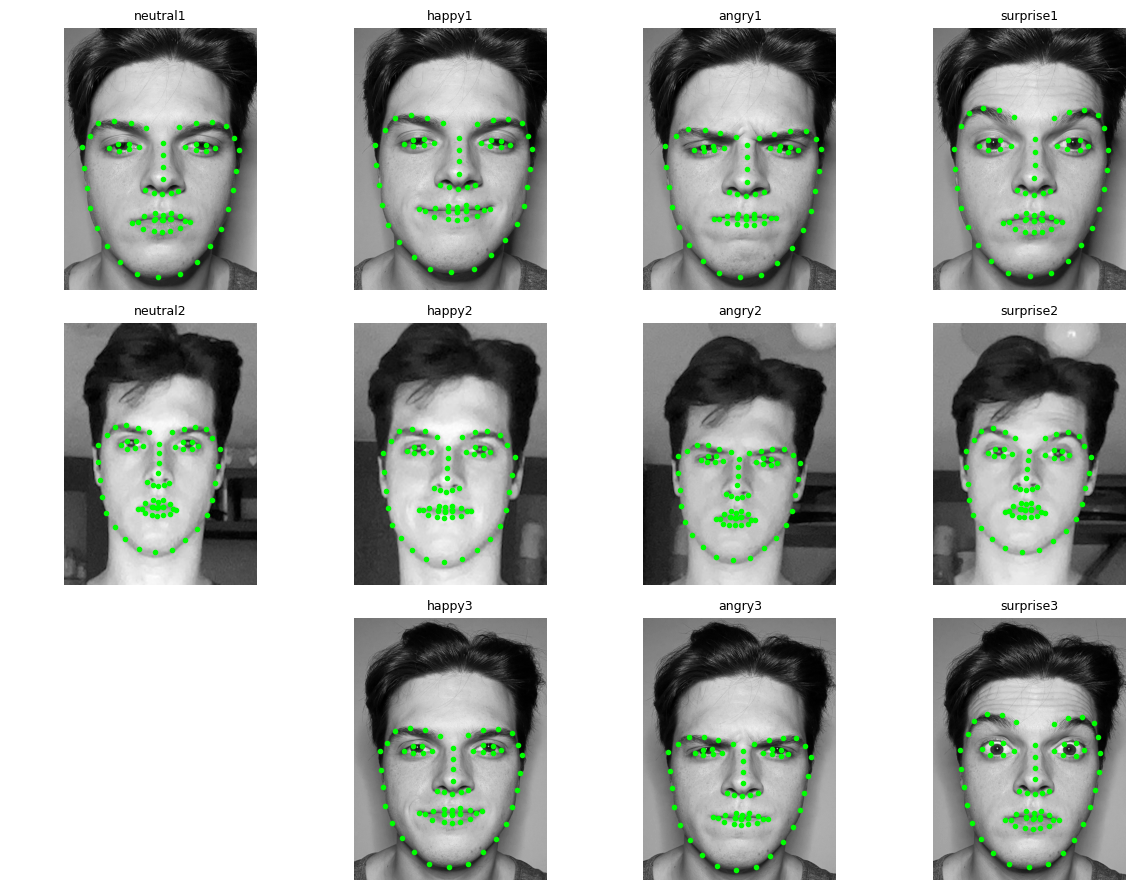

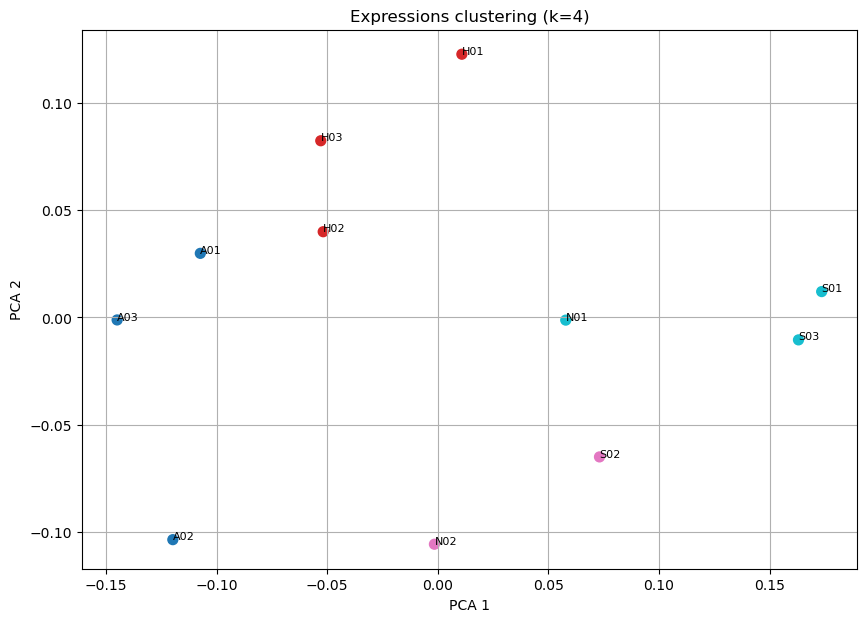

Cluster 0: ['angry_01', 'angry_02', 'angry_03']
Cluster 1: ['happy_01', 'happy_02', 'happy_03']
Cluster 2: ['neutral_02', 'surprise_02']
Cluster 3: ['neutral_01', 'surprise_01', 'surprise_03']


In [46]:
personal_dict = {
    'neutral_01': 'my_data/neutral4.jpg',
    'happy_01': 'my_data/happy4.jpg',
    'angry_01': 'my_data/angry4.jpg',
    'surprise_01': 'my_data/surprise4.jpg',

    'neutral_02': 'my_data/far_neutral2.jpg',
    'happy_02': 'my_data/far_happy2.jpg',
    'angry_02': 'my_data/far_angry2.jpg',
    'surprise_02': 'my_data/far_surprise2.jpg',

    'neutral_03': 'my_data/occ_angry.jpg',
    'happy_03': 'my_data/happy5.jpg',
    'angry_03': 'my_data/angry5.jpg',
    'surprise_03': 'my_data/surprise5.jpg',
}

cluster_assignments = analyze_and_cluster(personal_dict, k=4, visualize=True, plot_faces=True )
for cluster_id in range(4):
    group = [label for label, cid in cluster_assignments.items() if cid == cluster_id]
    print(f"Cluster {cluster_id}: {group}")

### Supervised Classification

To further assess the quality of the extracted features, we introduce a supervised classification stage using a kernel-based SVM classifier.

In [47]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def train_emotion_classifier(imgs_dict):
    features = []
    labels = []
    failed = []

    for label, path in imgs_dict.items():
        try:
            img, lm_coords = extract_landmarks(path)
            feat = extract_features(lm_coords)
            emotion = label.split('_')[0]  # 'neutral', 'happy', etc.
            features.append(feat)
            labels.append(emotion)
        except Exception as e:
            print(f"Failed on {label}: {e}")
            failed.append(label)

    if not features:
        raise ValueError("No features extracted successfully.")

    X = np.array(features)
    y = np.array(labels)

    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, stratify=y, random_state=42
    )

    # train SVM with RBF kernel
    clf = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42)
    )
    clf.fit(X_train, y_train)

    # predict and evaluate
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return clf



Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        15
       happy       1.00      0.93      0.97        15
     neutral       0.82      0.93      0.87        15
    surprise       0.93      0.87      0.90        15

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



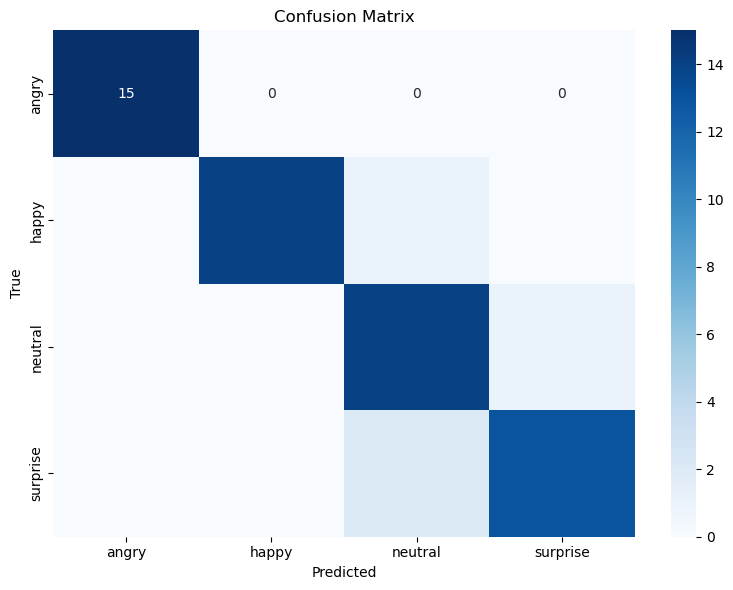

In [48]:
classifier = train_emotion_classifier(imgs_dict)

In [49]:
def test_emotion_classifier(clf, imgs_dict):
    features = []
    labels = []
    failed = []
    
    for label, path in imgs_dict.items():
        try:
            img, lm_coords = extract_landmarks(path)
            feat = extract_features(lm_coords)
            emotion = label.split('_')[0]
            features.append(feat)
            labels.append(emotion)
        except Exception as e:
            print(f"Failed on {label}: {e}")
            failed.append(label)

    if not features:
        raise ValueError("No test features extracted successfully.")

    X = np.array(features)
    y_true = np.array(labels)

    # predict using the trained classifier
    y_pred = clf.predict(X)

    # report
    print("Classification Report (Test Set):")
    print(classification_report(y_true, y_pred))

    # confusion matrix
    from sklearn.utils.multiclass import unique_labels
    classes = unique_labels(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_pred, failed


Classification Report (Test Set):
              precision    recall  f1-score   support

       angry       0.75      1.00      0.86         3
       happy       0.75      1.00      0.86         3
     neutral       1.00      0.33      0.50         3
    surprise       1.00      1.00      1.00         3

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.80        12
weighted avg       0.88      0.83      0.80        12



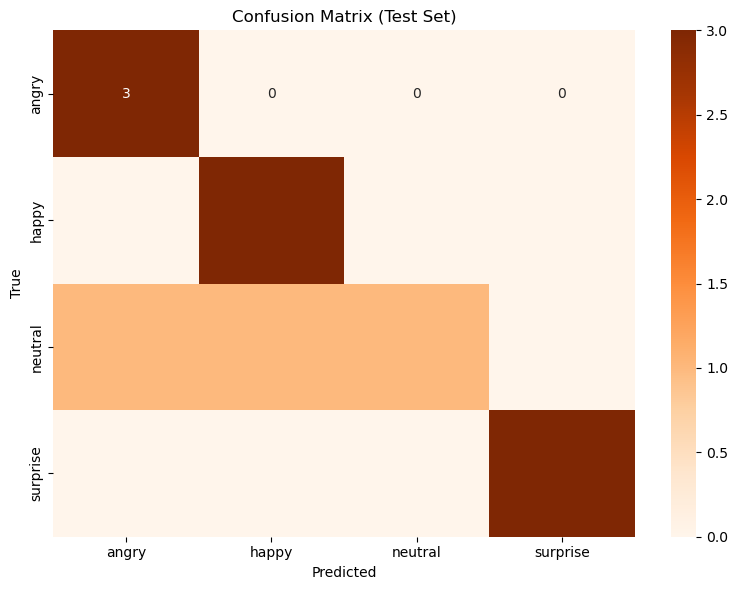

[]

In [50]:
personal_dict = {
    'neutral_01': 'my_data/neutral4.jpg',
    'happy_01': 'my_data/happy4.jpg',
    'angry_01': 'my_data/angry4.jpg',
    'surprise_01': 'my_data/surprise4.jpg',

    'neutral_02': 'my_data/neutral02.jpg',
    'happy_02': 'my_data/happy02.jpg',
    'angry_02': 'my_data/angry02.jpg',
    'surprise_02': 'my_data/surprise02.jpg',

    'neutral_03': 'my_data/neutral5.jpg',
    'happy_03': 'my_data/happy5.jpg',
    'angry_03': 'my_data/angry5.jpg',
    'surprise_03': 'my_data/surprise5.jpg',
}

y_pred , failed = test_emotion_classifier(classifier,personal_dict)
y_pred
failed